# GP Method Comparison

Compare different GP training approaches focusing on:
- Training time cost
- Prediction accuracy (test_plot style)
- Save all plots to save_dir
- Load pre-trained models for Methods 1-3 from trained_gp_models/GP_comparison_090625
- Use conditional_gp training for Method 4 with different kernel types

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from datetime import datetime

jax.config.update("jax_enable_x64", True)
np.random.seed(42)

# Setup save directory
save_dir = f"trained_gp_models/GP_comparison_{datetime.now().strftime('%m%d%y')}"
os.makedirs(save_dir, exist_ok=True)
print(f"Results will be saved to: {save_dir}")

# Path to pre-trained models
pretrained_dir = "trained_gp_models/GP_comparison_090625"
print(f"Loading pre-trained models from: {pretrained_dir}")

/global/u1/l/lindajin/virtualenvs/env1/lib/python3.11/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.1 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Results will be saved to: trained_gp_models/GP_comparison_090625
Loading pre-trained models from: trained_gp_models/GP_comparison_090625


In [2]:
# Import modules
import importlib
import GP_dataloader
importlib.reload(GP_dataloader) 
from GP_dataloader import *
import train_GP
importlib.reload(train_GP) 
from train_GP import *

try:
    from src.models.improved_kernels import *
    IMPROVED_AVAILABLE = True
    print("✅ Improved trainer available")
except ImportError:
    IMPROVED_AVAILABLE = False
    print("❌ Improved trainer not available")

JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
✅ Improved trainer available


In [3]:
# Load data
sim_indices_train = np.load('data/sparse_sampling_train_indices_random.npy')  
sim_indices_test = sim_indices_train[:20]  # Use subset for testing
sim_subset = sim_indices_train[:20]  # Same subset used in original training

print(f"Training: {len(sim_indices_train)} sims, Testing: {len(sim_indices_test)} sims")
print(f"Using subset: {len(sim_subset)} sims (same as original training)")

# Load test data
X_test, y_test, r_bins, k_bins = prepare_GP_data(sim_indices_test, 'CAP', 'gas')
print(f"Test data: X={X_test.shape}, y={y_test.shape}")

# Load training data for predictions
X_train, y_train, _, _ = prepare_GP_data(sim_subset, 'CAP', 'gas')
print(f"Train data: X={X_train.shape}, y={y_train.shape}")

Training: 204 sims, Testing: 20 sims
Using subset: 20 sims (same as original training)
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 255)
Test data: X=(1360, 291), y=(1360, 21)
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 255)
Train data: X=(1360, 291), y=(1360, 21)


## Method 1: Load Pre-trained NN+GP Model

In [4]:
print("=== Method 1: Loading Pre-trained NN+GP Model ===")
start_time = time.time()

# Load pre-trained parameters
with open(os.path.join(pretrained_dir, "best_params_nn_list.pkl"), "rb") as f:
    best_params_nn = pickle.load(f)
with open(os.path.join(pretrained_dir, "model_info_nn_list.pkl"), "rb") as f:
    model_info_nn = pickle.load(f)

nn_load_time = time.time() - start_time
print(f"NN+GP model loading time: {nn_load_time:.3f}s")
print(f"Loaded {len(best_params_nn)} trained NN+GP models")

=== Method 1: Loading Pre-trained NN+GP Model ===
NN+GP model loading time: 0.034s
Loaded 21 trained NN+GP models


In [5]:
# Generate NN+GP predictions
print("Generating NN+GP predictions...")
pred_start = time.time()

pred_means_nn = []
pred_vars_nn = []
model = build_NN_gp()

for i in range(len(best_params_nn)):
    cond_gp = model.apply(best_params_nn[i], X_test, y_train[:,i])[1]
    pred_means_nn.append(cond_gp.mean)
    pred_vars_nn.append(cond_gp.variance)

pred_means_nn = np.array(pred_means_nn)
pred_vars_nn = np.array(pred_vars_nn)
nn_pred_time = time.time() - pred_start
print(f"NN+GP predictions shape: {pred_means_nn.shape} (generated in {nn_pred_time:.2f}s)")

Generating NN+GP predictions...
NN+GP predictions shape: (21, 1360) (generated in 9.92s)


## Method 2: Load Pre-trained Hierarchical GP Model

In [6]:
print("=== Method 2: Loading Pre-trained Hierarchical GP Model ===")
start_time = time.time()

# Load pre-trained parameters
with open(os.path.join(pretrained_dir, "best_params_hier_list.pkl"), "rb") as f:
    best_params_hier = pickle.load(f)
with open(os.path.join(pretrained_dir, "model_info_hier_list.pkl"), "rb") as f:
    model_info_hier = pickle.load(f)

hier_load_time = time.time() - start_time
print(f"Hierarchical GP model loading time: {hier_load_time:.3f}s")
print(f"Loaded {len(best_params_hier)} trained Hierarchical GP models")

=== Method 2: Loading Pre-trained Hierarchical GP Model ===
Hierarchical GP model loading time: 0.033s
Loaded 21 trained Hierarchical GP models


In [7]:
# Generate Hierarchical GP predictions
print("Generating Hierarchical GP predictions...")
pred_start = time.time()

# Rebuild GP models from saved parameters
gp_models_hier = []
for i in range(len(best_params_hier)):
    gp_model = build_hierarchical_gp(best_params_hier[i], X_train)
    gp_models_hier.append(gp_model)

pred_means_hier = []
pred_vars_hier = []

for i, gp_model in enumerate(gp_models_hier):
    _, cond_gp = gp_model.condition(y_train[:, i], X_test)
    pred_means_hier.append(cond_gp.mean)
    pred_vars_hier.append(cond_gp.variance)

pred_means_hier = np.array(pred_means_hier)
pred_vars_hier = np.array(pred_vars_hier)
hier_pred_time = time.time() - pred_start
print(f"Hierarchical GP predictions shape: {pred_means_hier.shape} (generated in {hier_pred_time:.2f}s)")

Generating Hierarchical GP predictions...
Hierarchical GP predictions shape: (21, 1360) (generated in 27.30s)


## Method 3: Training with Different Kernel Types

=== Method 4: JAX-Compatible Training with Different Kernels ===

Training with multiscale kernel...
Testing robust kernel with train_GP.py framework...
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 255)


Training GP for each r_bin: 100%|██████████| 21/21 [1:01:17<00:00, 175.14s/it]


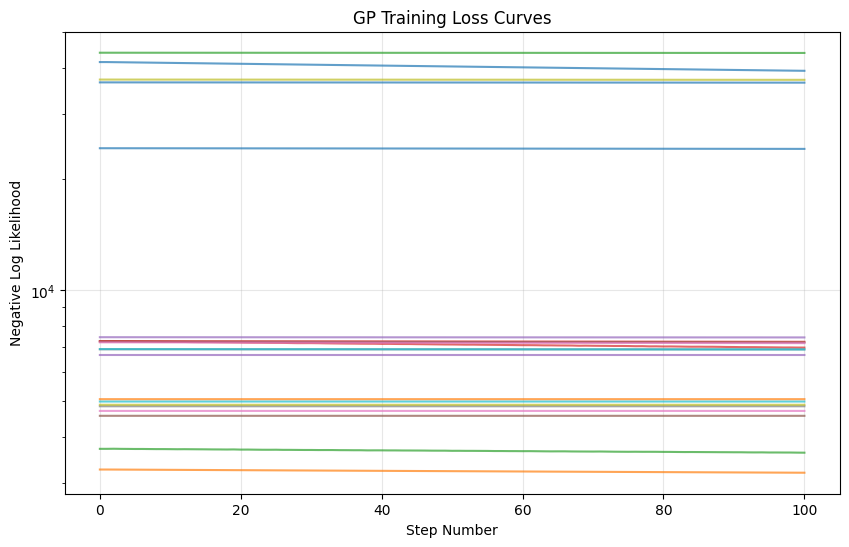

multiscale kernel training time: 3678.8s
multiscale predictions shape: (21, 1360) (generated in 29.63s)

Training with physics_informed kernel...
Testing multiscale kernel with train_GP.py framework...
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 255)


Training GP for each r_bin: 100%|██████████| 21/21 [54:29<00:00, 155.69s/it]


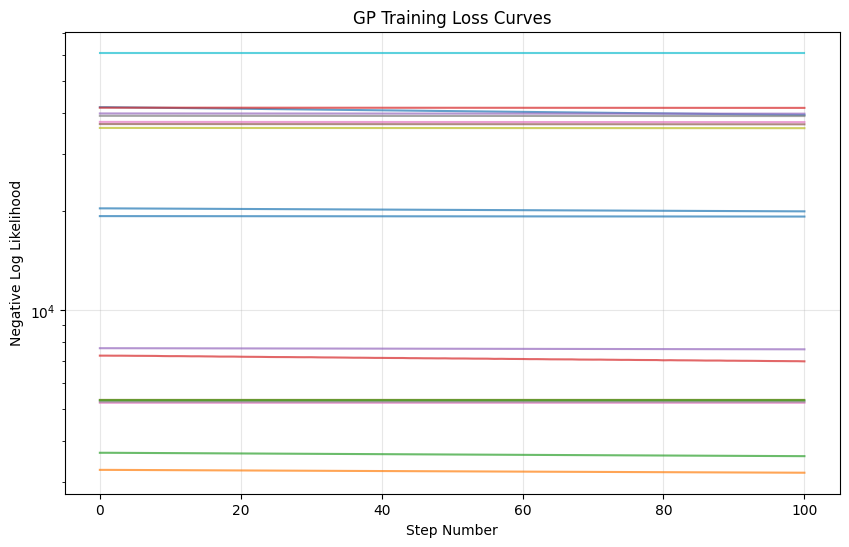

physics_informed kernel training time: 3270.0s
physics_informed predictions shape: (21, 1360) (generated in 35.28s)

Training with robust kernel...
Testing physics-informed kernel with train_GP.py framework...
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 255)


Training GP for each r_bin: 100%|██████████| 21/21 [1:10:08<00:00, 200.38s/it]


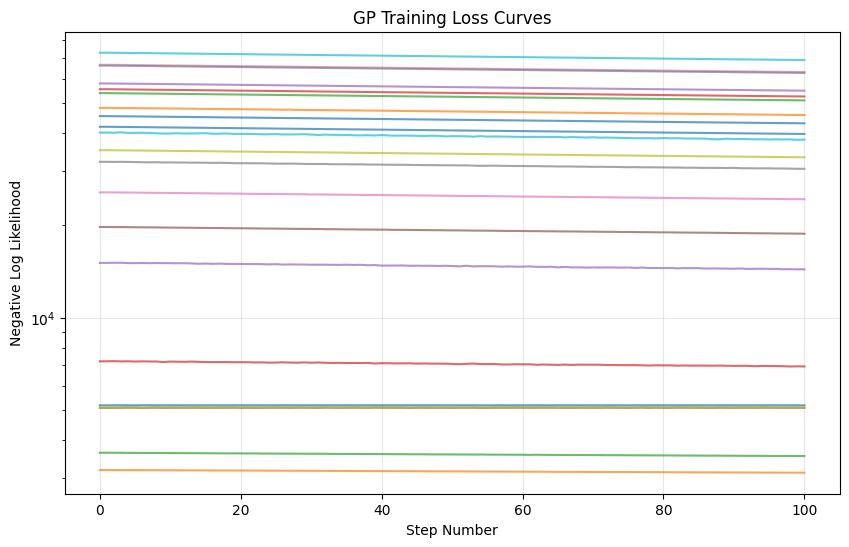

robust kernel training time: 4208.6s
robust predictions shape: (21, 1360) (generated in 46.00s)

✅ Completed training with 3 kernel types


In [8]:
import importlib
import src.models.kernel_integration
importlib.reload(src.models.kernel_integration)
from src.models.kernel_integration import test_multiscale_training, test_physics_informed_training, test_robust_training

if IMPROVED_AVAILABLE:
    print("=== Method 4: JAX-Compatible Training with Different Kernels ===")
    
    # Define kernel types to compare
    kernel_types = ['multiscale', 'physics_informed', 'robust']
    kernel_funcs = [test_robust_training, test_multiscale_training, test_physics_informed_training]
    kernel_results = {}

    for kernel_name, kernel_func in zip(kernel_types,kernel_funcs):
        print(f"\nTraining with {kernel_name} kernel...")
        start_time = time.time()
        
        try:
            # Train with current kernel
            gp_models, best_params, model_info = kernel_func(
                sim_subset
            )
            
            train_time = time.time() - start_time
            print(f"{kernel_name} kernel training time: {train_time:.1f}s")
            
            # Save trained model
            with open(os.path.join(save_dir, f"best_params_{kernel_name}_list.pkl"), "wb") as f:
                pickle.dump(best_params, f)
            with open(os.path.join(save_dir, f"model_info_{kernel_name}_list.pkl"), "wb") as f:
                pickle.dump(model_info, f)
            
            # Generate predictions
            pred_start = time.time()
            pred_means = []
            pred_vars = []
            
            for i, gp_model in enumerate(gp_models):
                _, cond_gp = gp_model.condition(y_train[:, i], X_test)
                pred_means.append(cond_gp.mean)
                pred_vars.append(cond_gp.variance)
            
            pred_means = np.array(pred_means)
            pred_vars = np.array(pred_vars)
            pred_time = time.time() - pred_start
            
            kernel_results[kernel_name] = {
                'train_time': train_time,
                'pred_time': pred_time,
                'pred_means': pred_means,
                'pred_vars': pred_vars,
                'models': gp_models,
                'params': best_params
            }
            
            print(f"{kernel_name} predictions shape: {pred_means.shape} (generated in {pred_time:.2f}s)")
            
        except Exception as e:
            print(f"❌ {kernel_name} kernel failed: {e}")
            kernel_results[kernel_name] = {'error': str(e)}
    
    print(f"\n✅ Completed training with {len([k for k, v in kernel_results.items() if 'error' not in v])} kernel types")
    
else:
    print("Method 4 skipped - JAX-compatible trainer not available")
    kernel_results = {}

## Training/Loading Time Comparison

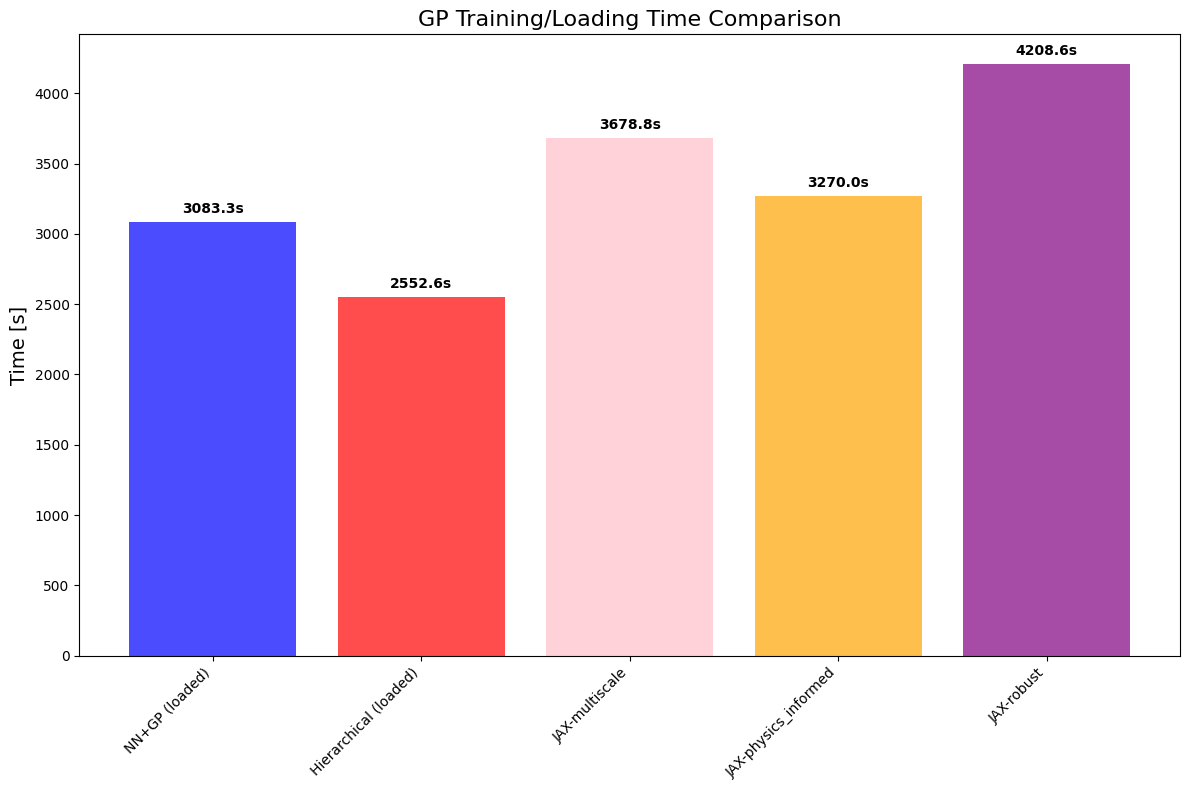

Time Summary:
  NN+GP (loaded): 3083.3s
  Hierarchical (loaded): 2552.6s
  JAX-multiscale: 3678.8s
  JAX-physics_informed: 3270.0s
  JAX-robust: 4208.6s


In [18]:
# Compile all timing results
methods = ['NN+GP (loaded)', 'Hierarchical (loaded)']
nn_load_time = 3083.3
hier_load_time = 2552.6
times = [nn_load_time, hier_load_time]
colors = ['blue', 'red']


# Add kernel training times
if kernel_results:
    for kernel_name, results in kernel_results.items():
        if 'error' not in results:
            methods.append(f'JAX-{kernel_name}')
            times.append(results['train_time'])
            colors.append(['orange', 'purple', 'brown', 'pink'][len(methods)-4])

# Plot comparison
plt.figure(figsize=(12, 8))
bars = plt.bar(methods, times, color=colors, alpha=0.7)
plt.ylabel('Time [s]', fontsize=14)
plt.title('GP Training/Loading Time Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
             f'{time_val:.3f}s' if time_val < 1 else f'{time_val:.1f}s', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{save_dir}/training_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Time Summary:")
for method, time_val in zip(methods, times):
    print(f"  {method}: {time_val:.3f}s" if time_val < 1 else f"  {method}: {time_val:.1f}s")

## Test Plot Comparison

In [10]:
# Compute ground truth statistics
upper = np.quantile(y_test, 0.25, axis=0)
lower = np.quantile(y_test, 0.75, axis=0)
median = np.median(y_test, axis=0)
yerr_lower = np.abs(median - lower)
yerr_upper = np.abs(upper - median)
yerr_truth = [yerr_lower, yerr_upper]

print(f"Ground truth computed for {len(r_bins)} radius bins")

Ground truth computed for 21 radius bins


/tmp/ipykernel_1777370/2895791421.py:25: RuntimeWarning: invalid value encountered in sqrt
  ax.fill_between(r_bins, median_pred - np.mean(np.sqrt(pred_vars), axis=1),
/tmp/ipykernel_1777370/2895791421.py:26: RuntimeWarning: invalid value encountered in sqrt
  median_pred + np.mean(np.sqrt(pred_vars), axis=1),


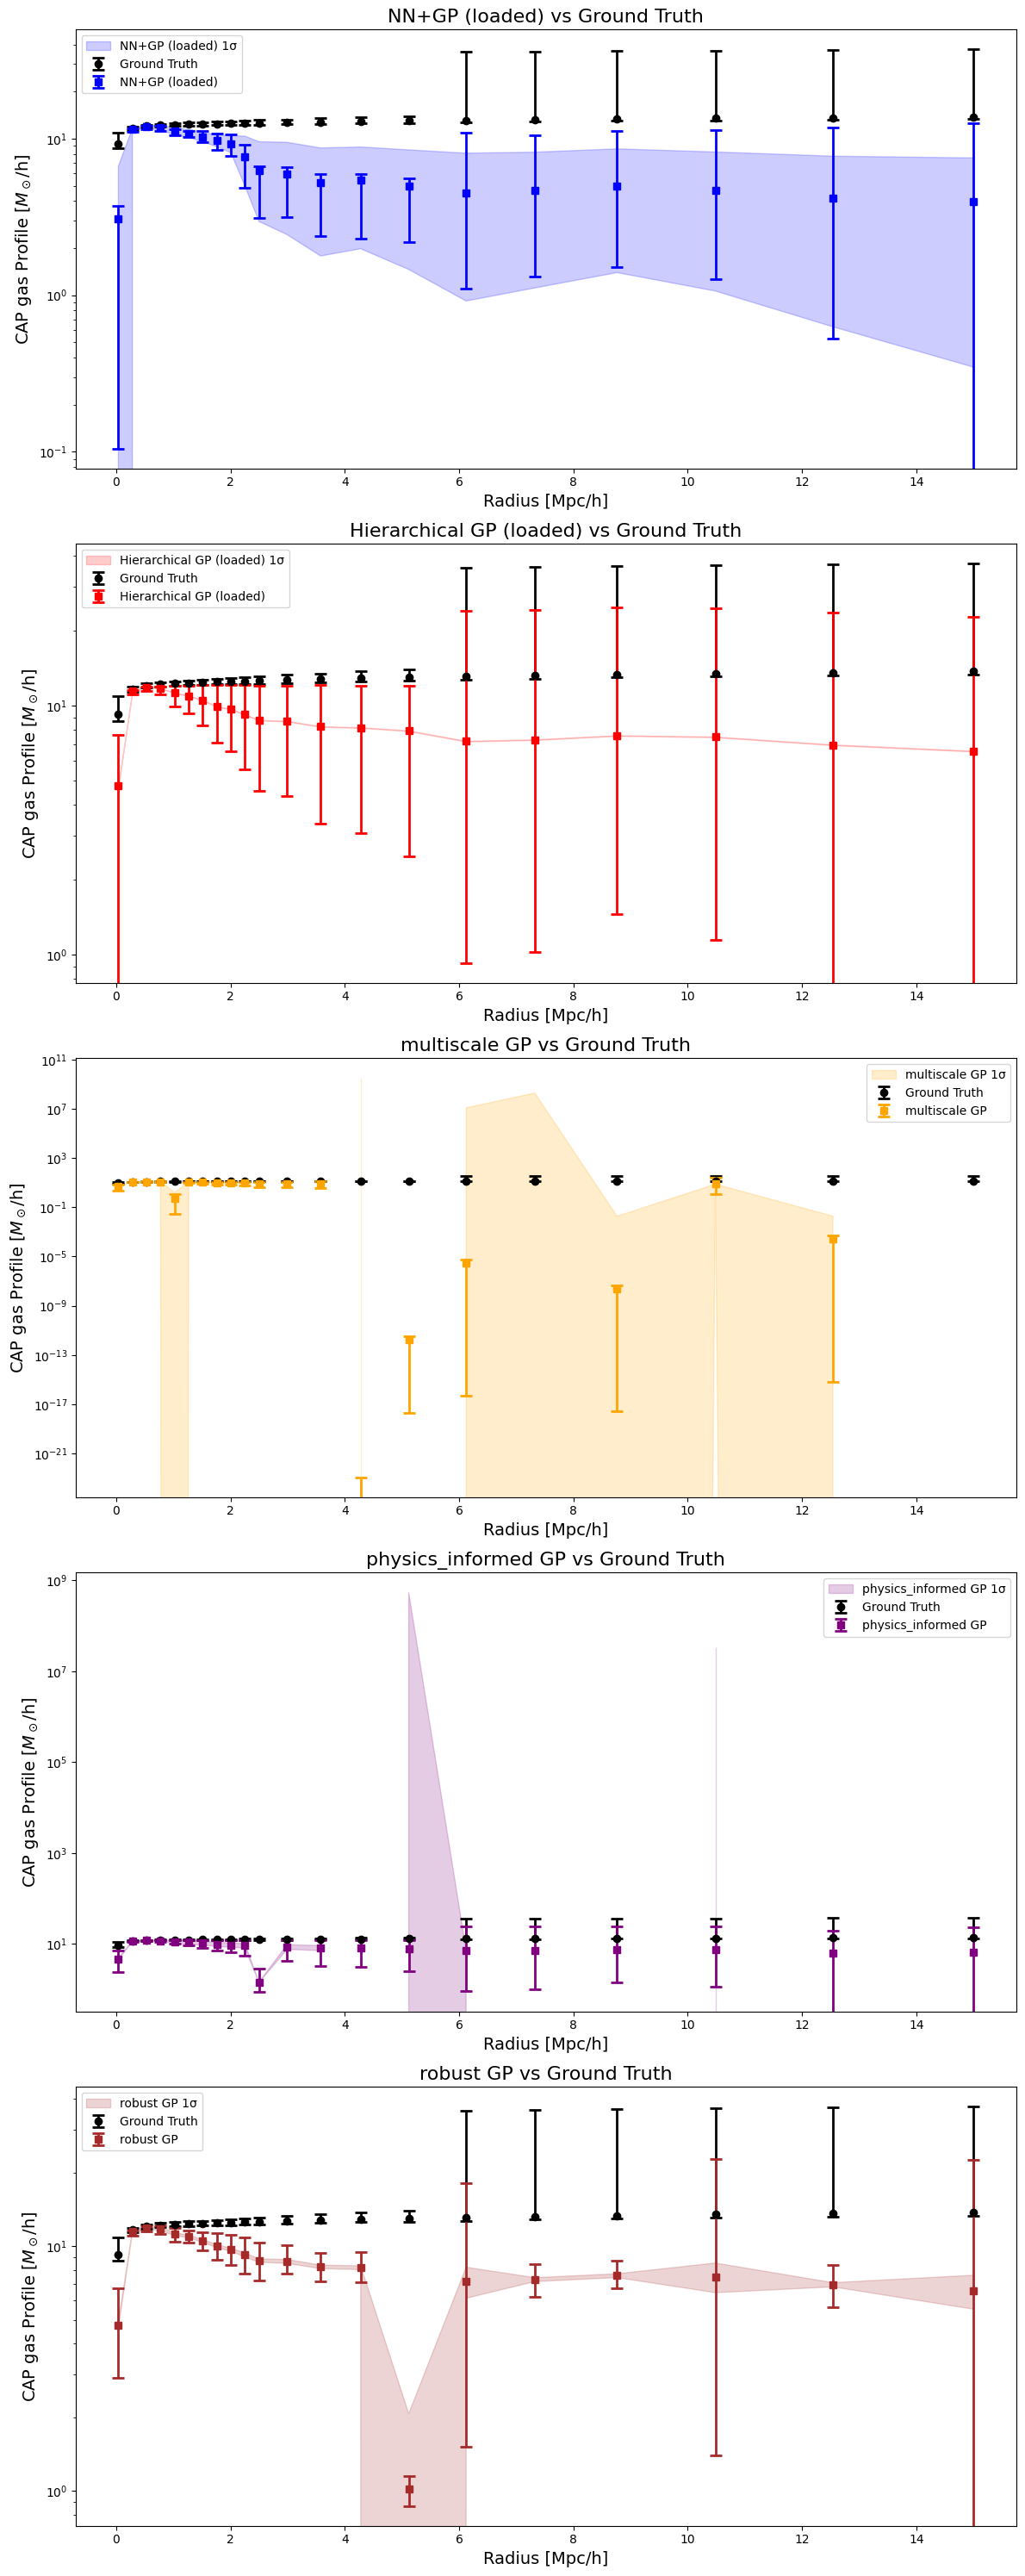

In [22]:
# Create comprehensive comparison plot
n_plots = 2 + len([k for k, v in kernel_results.items() if 'error' not in v])
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6*n_plots))
if n_plots == 1:
    axes = [axes]

plot_idx = 0

# Helper function to plot method comparison
def plot_method_comparison(ax, pred_means, pred_vars, method_name, color):
    # Ground truth
    ax.errorbar(r_bins, median, yerr=yerr_truth, fmt='o', capsize=5, capthick=2, 
                linewidth=2, markersize=6, color='black', label='Ground Truth')
    
    # Predictions
    upper_pred = np.quantile(pred_means, 0.25, axis=1)
    lower_pred = np.quantile(pred_means, 0.75, axis=1)
    median_pred = np.mean(pred_means, axis=1)
    yerr_lower_pred = np.abs(median_pred - lower_pred)
    yerr_upper_pred = np.abs(upper_pred - median_pred)
    yerr_pred = [yerr_lower_pred, yerr_upper_pred]
    
    ax.errorbar(r_bins, median_pred, yerr=yerr_pred, fmt='s', capsize=5, 
                capthick=2, linewidth=2, markersize=6, color=color, label=method_name)
    ax.fill_between(r_bins, median_pred - np.mean(np.sqrt(pred_vars), axis=1), 
                    median_pred + np.mean(np.sqrt(pred_vars), axis=1), 
                    color=color, alpha=0.2, label=f'{method_name} 1σ')
    
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Radius [Mpc/h]', fontsize=14)
    ax.set_ylabel(r'CAP gas Profile [$M_\odot$/h]', fontsize=14)
    ax.set_title(f'{method_name} vs Ground Truth', fontsize=16)
    
    # Compute percentage error
    percent_error = 100 * (median_pred - median) / median
    return percent_error

# Plot loaded models
if plot_idx < len(axes):
    error_nn = plot_method_comparison(axes[plot_idx], pred_means_nn, pred_vars_nn, 
                                     'NN+GP (loaded)', 'blue')
    plot_idx += 1

if plot_idx < len(axes):
    error_hier = plot_method_comparison(axes[plot_idx], pred_means_hier, pred_vars_hier, 
                                       'Hierarchical GP (loaded)', 'red')
    plot_idx += 1

# Plot kernel comparisons
kernel_colors = ['orange', 'purple', 'brown', 'pink']
kernel_errors = {}

color_idx = 0
for kernel_name, results in kernel_results.items():
    if 'error' not in results and plot_idx < len(axes):
        kernel_errors[kernel_name] = plot_method_comparison(
            axes[plot_idx], results['pred_means'], results['pred_vars'], 
            f'{kernel_name} GP', kernel_colors[color_idx % len(kernel_colors)]
        )
        plot_idx += 1
        color_idx += 1

plt.tight_layout()
plt.savefig(f'{save_dir}/test_plot_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Percentage Error Comparison

/tmp/ipykernel_1777370/4094703007.py:13: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = np.mean(np.sqrt(pred_vars), axis=1)


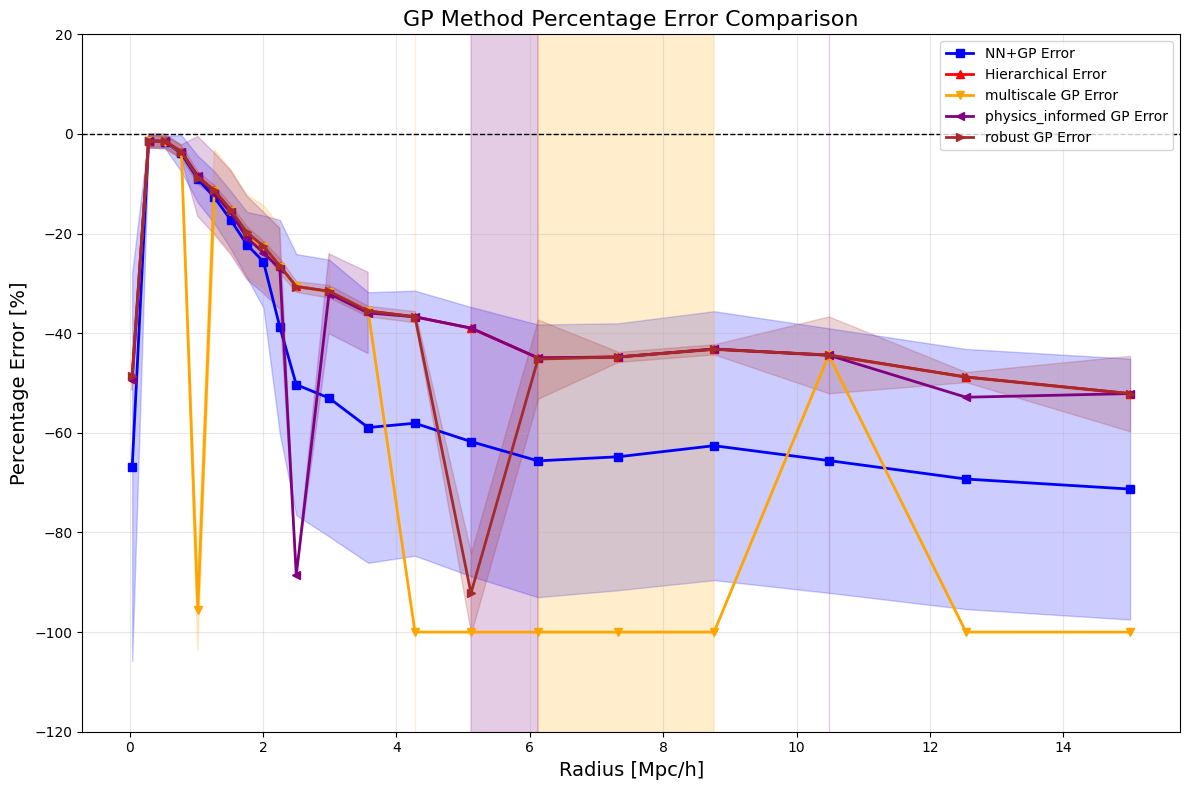

In [23]:
# Create percentage error comparison plot
plt.figure(figsize=(12, 8))

# Helper function for percentage error
def compute_percentage_error(pred_means, pred_vars, label, color, marker='o'):
    median_pred = np.mean(pred_means, axis=1)
    percent_error = 100 * (median_pred - median) / median
    
    plt.plot(r_bins, percent_error, marker=marker, linestyle='-', 
             color=color, linewidth=2, markersize=6, label=f'{label} Error')
    
    # Add uncertainty bands
    uncertainty = np.mean(np.sqrt(pred_vars), axis=1)
    error_upper = 100 * (median_pred + uncertainty - median) / median
    error_lower = 100 * (median_pred - uncertainty - median) / median
    
    plt.fill_between(r_bins, error_lower, error_upper, color=color, alpha=0.2)
    
    return percent_error

# Plot errors for all methods
error_nn = compute_percentage_error(pred_means_nn, pred_vars_nn, 'NN+GP', 'blue', 's')
error_hier = compute_percentage_error(pred_means_hier, pred_vars_hier, 'Hierarchical', 'red', '^')

# Plot kernel errors
markers = ['v', '<', '>', 'p']
for i, (kernel_name, results) in enumerate(kernel_results.items()):
    if 'error' not in results:
        compute_percentage_error(results['pred_means'], results['pred_vars'], 
                               f'{kernel_name} GP', kernel_colors[i % len(kernel_colors)], 
                               markers[i % len(markers)])

plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Radius [Mpc/h]', fontsize=14)
plt.ylabel('Percentage Error [%]', fontsize=14)
plt.ylim([-120,20])
plt.title('GP Method Percentage Error Comparison', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{save_dir}/percentage_error_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Statistics

In [24]:
# Compute summary metrics
def compute_summary_metrics(pred_means, pred_vars, ground_truth, method_name):
    pred_median = np.mean(pred_means, axis=1)
    
    # Only use valid (non-NaN) data points
    valid_mask = ~(np.isnan(pred_median) | np.isnan(ground_truth))
    
    if not np.any(valid_mask):
        return f"{method_name}: No valid predictions"
    
    pred_valid = pred_median[valid_mask]
    gt_valid = ground_truth[valid_mask]
    
    # Compute metrics
    mse = np.mean((pred_valid - gt_valid)**2)
    mae = np.mean(np.abs(pred_valid - gt_valid))
    mape = np.mean(np.abs((pred_valid - gt_valid) / gt_valid)) * 100
    
    # High radius performance (last 5 bins)
    high_r_mask = valid_mask[-5:]
    if np.any(high_r_mask):
        high_r_mape = np.mean(np.abs((pred_median[-5:][high_r_mask] - ground_truth[-5:][high_r_mask]) / 
                                   ground_truth[-5:][high_r_mask])) * 100
    else:
        high_r_mape = np.nan
    
    return {
        'method': method_name,
        'mse': mse,
        'mae': mae,
        'mape': mape,
        'high_radius_mape': high_r_mape,
        'n_valid': np.sum(valid_mask)
    }

print("\n" + "="*70)
print("SUMMARY METRICS")
print("="*70)

# Compute metrics for all methods
all_metrics = []
all_metrics.append(compute_summary_metrics(pred_means_nn, pred_vars_nn, median, 'NN+GP (loaded)'))
all_metrics.append(compute_summary_metrics(pred_means_hier, pred_vars_hier, median, 'Hierarchical (loaded)'))


# Add kernel metrics
for kernel_name, results in kernel_results.items():
    if 'error' not in results:
        all_metrics.append(compute_summary_metrics(results['pred_means'], results['pred_vars'], 
                                                  median, f'{kernel_name} GP'))

print(f"{'Method':<20} {'Valid':<5} {'MSE':<10} {'MAE':<10} {'MAPE%':<8} {'HighR%':<8}")
print("-" * 75)

for metrics in all_metrics:
    if isinstance(metrics, dict):
        print(f"{metrics['method']:<20} {metrics['n_valid']:<5} "
              f"{metrics['mse']:<10.2e} {metrics['mae']:<10.2e} "
              f"{metrics['mape']:<8.1f} {metrics['high_radius_mape']:<8.1f}")
    else:
        print(metrics)

print(f"\nTime Summary:")
for method, time_val in zip(methods, times):
    print(f"  {method}: {time_val:.3f}s" if time_val < 1 else f"  {method}: {time_val:.1f}s")

print(f"\n📁 All plots saved to: {save_dir}/")


SUMMARY METRICS
Method               Valid MSE        MAE        MAPE%    HighR%  
---------------------------------------------------------------------------
NN+GP (loaded)       21    3.97e+01   5.36e+00   41.9     66.7    
Hierarchical (loaded) 21    1.84e+01   3.71e+00   29.1     46.7    
multiscale GP        21    7.22e+01   6.70e+00   51.9     88.9    
physics_informed GP  21    2.42e+01   4.12e+00   32.3     47.5    
robust GP            21    2.41e+01   4.04e+00   31.6     46.7    

Time Summary:
  NN+GP (loaded): 3083.3s
  Hierarchical (loaded): 2552.6s
  JAX-multiscale: 3678.8s
  JAX-physics_informed: 3270.0s
  JAX-robust: 4208.6s

📁 All plots saved to: trained_gp_models/GP_comparison_090625/


In [25]:
# Save comprehensive summary data
summary = {
    'timestamp': datetime.now().isoformat(),
    'loading_training_times': dict(zip(methods, times)),
    'kernel_comparison_results': {
        kernel: {'train_time': results.get('train_time', None), 
                'pred_time': results.get('pred_time', None),
                'error': results.get('error', None)}
        for kernel, results in kernel_results.items()
    },
    'metrics': {
        metrics['method'].replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').lower(): 
        metrics if isinstance(metrics, dict) else {'error': str(metrics)}
        for metrics in all_metrics
    },
    'data_info': {
        'n_train_sims': len(sim_subset),
        'n_test_sims': len(sim_indices_test),
        'n_radius_bins': len(r_bins),
        'filter_type': 'CAP',
        'particle_type': 'gas',
        'pretrained_models_from': pretrained_dir
    }
}

import json
with open(f'{save_dir}/comparison_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"Comprehensive summary saved to: {save_dir}/comparison_summary.json")
print("\n✅ GP method comparison with JAX-compatible kernels complete!")

Comprehensive summary saved to: trained_gp_models/GP_comparison_090625/comparison_summary.json

✅ GP method comparison with JAX-compatible kernels complete!


In [26]:
pred_means.shape

(21, 1360)